<a href="https://colab.research.google.com/github/psychlone77/210125B-CS2023/blob/main/ComponentPrediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameters/Variables

In [168]:
RETRAIN = True
FILE_PATH_STRING = "/content/drive/My Drive/Colab Notebooks/final_ann.json"
MODEL_PATH_STRING = "/content/drive/My Drive/Colab Notebooks/models"
MODEL_NAME = "predictor_component"
type_mapping = {
  'anchor': 0,
  'shackle': 1,
  'chain': 2,
  'ring': 3,
  'rope': 4,
  'flexiLink': 5,
  'trawlFloat': 6,
  'eyebolt': 7,
  'cornerPlate': 8,
  'koblPlate': 9,
  'bouy': 10,
  'concreteBlock': 11,
  'bouyLight': 12,
}
#101cp check 5
type_mapping_reverse = {v: k for k, v in type_mapping.items()}
extracted_data = []

# Hyper-Parameters

In [169]:
EMBED_DIM = 80 # Check on how to optimize this, maybe use different dims for type and locations
NUM_LAYERS = 4
NUM_HEADS = 8
MAX_SEQ_LEN = 50
DROPOUT = 0.001
NUM_COMPONENT_TYPES = len(type_mapping)
BATCH_SIZE = 2
USE_TEACHER_FORCING = False
LEARNING_RATE = 0.001
EPOCHS = 100

# Helper Functions

In [170]:
import pprint

def pretty_print(d):
  pprint.pprint(d, sort_dicts=False)

In [171]:
from pathlib import Path
from google.colab import drive

model_path = Path(MODEL_PATH_STRING)
model_save_path = model_path / MODEL_NAME

def save_model(model):
  model_path.mkdir(parents=True, exist_ok=True)
  torch.save(obj=model.state_dict(), f=model_save_path)

def load_model(model):
  model.load_state_dict(torch.load(f=model_save_path))

# JSON Data Loading

In [172]:
from pathlib import Path
from google.colab import drive
import json

FILE_PATH = Path(FILE_PATH_STRING)

try:
    with open(FILE_PATH, 'r') as f:
        data = json.load(f)

except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}")
except json.JSONDecodeError:
    print(f"Error: Invalid JSON format in {FILE_PATH}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

for template in data:
  types = []
  locations = []
  # print(template['annotations'][0]['result'])
  for component in template['annotations'][0]['result']:
    useful_data = component['value']
    label = useful_data['rectanglelabels'][0]
    x = useful_data['x']
    y = -useful_data['y']
    types.append(type_mapping[label])
    locations.append((x, y))
  extracted_data.append({'types': types, 'locations': locations})

pretty_print(extracted_data[0])

{'types': [0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 4, 5, 6],
 'locations': [(3.5928754366897757, -74.86703130761232),
               (15.944956846555765, -74.59566353410342),
               (17.40470641701521, -75.22821591404902),
               (21.50323405715102, -75.30728496154208),
               (23.58056998434318, -76.01890638898075),
               (27.735241838727458, -76.25611353146027),
               (29.531856694677415, -76.65145876892616),
               (33.967249620303875, -76.57238972143297),
               (36.156873975992845, -76.09797543647386),
               (40.704555330116214, -74.99100877156947),
               (42.61345861456287, -73.48869686919912),
               (46.69991532407503, -72.70937869225544),
               (47.92992700050125, -72.12118613102565),
               (49.465298937534435, -71.00136444687516),
               (76.16867318364984, -57.229774499901),
               (60.56861970855114, -54.338346865319686)]}


In [173]:
# Test here with extracted data
import torch
sample = extracted_data[0]
types = torch.tensor(sample['types'], dtype=torch.uint8)
locations = torch.tensor(sample['locations'], dtype=torch.float16)
pretty_print({'types': types, 'locations': locations})

{'types': tensor([0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 4, 5, 6], dtype=torch.uint8),
 'locations': tensor([[  3.5938, -74.8750],
        [ 15.9453, -74.6250],
        [ 17.4062, -75.2500],
        [ 21.5000, -75.3125],
        [ 23.5781, -76.0000],
        [ 27.7344, -76.2500],
        [ 29.5312, -76.6250],
        [ 33.9688, -76.5625],
        [ 36.1562, -76.1250],
        [ 40.7188, -75.0000],
        [ 42.6250, -73.5000],
        [ 46.6875, -72.6875],
        [ 47.9375, -72.1250],
        [ 49.4688, -71.0000],
        [ 76.1875, -57.2188],
        [ 60.5625, -54.3438]], dtype=torch.float16)}


# Dataset Class

In [174]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data):
        """
        data: list of samples. Each sample is a dict with:
          - "types": list of ints representing component types.
          - "locations": list of tuples (x, y) for each component.
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        types = torch.tensor(sample['types'], dtype=torch.uint8)
        locations = torch.tensor(sample['locations'], dtype=torch.float16)
        return {'types': types, 'locations': locations}

def collate_fn(batch):
    # Pad sequences to the same length in a batch.
    batch_types = [item['types'] for item in batch]
    batch_locations = [item['locations'] for item in batch]
    seq_lengths = [len(x) for x in batch_types]
    max_len = max(seq_lengths)
    padded_types = torch.zeros(len(batch), max_len, dtype=torch.long)
    padded_locations = torch.zeros(len(batch), max_len, 2, dtype=torch.float)
    mask = torch.zeros(len(batch), max_len, dtype=torch.bool)
    for i, (types, locs) in enumerate(zip(batch_types, batch_locations)):
        length = len(types)
        padded_types[i, :length] = types
        padded_locations[i, :length, :] = locs
        mask[i, :length] = 1  # Mark valid tokens.
    return {'types': padded_types, 'locations': padded_locations, 'mask': mask}

# Model Architecture

In [175]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

In [176]:
import torch.nn as nn

class ComponentPredictor(nn.Module):
    def __init__(self, num_of_types, embed_dim, num_of_layers, num_of_heads, dropout, max_seq_len):
      super().__init__()
      self.embed_dim = embed_dim
      self.type_embedding = nn.Embedding(num_of_types, embed_dim)
      self.coord_embedding = nn.Linear(2, embed_dim)
      self.pos_encoding = PositionalEncoding(embed_dim, max_seq_len)

      encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_of_heads, dropout=dropout)
      self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_of_layers)

      self.type_head = nn.Linear(embed_dim, num_of_types)
      self.coord_head = nn.Linear(embed_dim, 2)

    def forward(self, types, locations, src_key_padding_mask=None):
        """
        locations: Tens
        types: Tensor of shape (batch, seq_len) -- component type indices.or of shape (batch, seq_len, 2) -- continuous coordinates.
        src_key_padding_mask: Boolean mask of shape (batch, seq_len) with True at padded positions.
        """
        # Embed type and location.
        type_embeds = self.type_embedding(types)  # (batch, seq_len, embed_dim)
        coord_embeds = self.coord_embedding(locations)  # (batch, seq_len, embed_dim)
        # Sum the embeddings.
        x = type_embeds + coord_embeds
        # Add positional encoding.
        x = self.pos_encoding(x)
        # Transformer expects shape (seq_len, batch, embed_dim).
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        x = x.transpose(0, 1)  # Back to (batch, seq_len, embed_dim)
        # Compute outputs at each time step.
        type_logits = self.type_head(x) # (batch, seq_len, num_types)
        loc_pred = self.coord_head(x) # (batch, seq_len, 2)
        return type_logits, loc_pred


# Training the Model

In [177]:
import torch.optim as optim
import torch.nn as nn

def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    criterion_type = nn.CrossEntropyLoss()
    criterion_loc = nn.MSELoss()
    for batch in dataloader:
        types = batch['types'].to(device)          # (batch, seq_len)
        locations = batch['locations'].to(device)    # (batch, seq_len, 2)
        mask = batch['mask'].to(device)              # (batch, seq_len)

        # Create input (all tokens except the last) and target (all tokens except the first).
        input_types = types[:, :-1]
        input_locations = locations[:, :-1]
        target_types = types[:, 1:]
        target_locations = locations[:, 1:]
        input_mask = mask[:, :-1]  # Valid positions in input.

        # Transformer expects a src_key_padding_mask where True values indicate positions to mask.
        src_key_padding_mask = ~input_mask  # Invert the mask (False for valid tokens).

        optimizer.zero_grad()
        type_logits, loc_pred = model(input_types, input_locations, src_key_padding_mask=src_key_padding_mask)
        # Reshape predictions and targets to compute loss.
        loss_type = criterion_type(type_logits.reshape(-1, NUM_COMPONENT_TYPES), target_types.reshape(-1))
        loss_loc = criterion_loc(loc_pred.reshape(-1, 2), target_locations.reshape(-1, 2))
        loss = loss_type + loss_loc
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [178]:
def train_tfa(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    criterion_type = nn.CrossEntropyLoss()
    criterion_loc = nn.MSELoss()
    for batch in dataloader:
        types = batch['types'].to(device)          # (batch, seq_len)
        locations = batch['locations'].to(device)  # (batch, seq_len, 2)
        mask = batch['mask'].to(device)            # (batch, seq_len)

        optimizer.zero_grad()
        batch_loss = 0.0

        # Loop through each position in the sequence
        for i in range(1, types.size(1)):
            input_types = types[:, :i]
            input_locations = locations[:, :i]
            target_types = types[:, i]
            target_locations = locations[:, i]
            input_mask = mask[:, :i]

            # Transformer expects a src_key_padding_mask where True values indicate positions to mask.
            src_key_padding_mask = ~input_mask  # Invert the mask (False for valid tokens).

            type_logits, loc_pred = model(input_types, input_locations, src_key_padding_mask=src_key_padding_mask)
            # Reshape predictions and targets to compute loss.
            loss_type = criterion_type(type_logits[:, -1, :], target_types)
            loss_loc = criterion_loc(loc_pred[:, -1, :], target_locations)
            loss = loss_type + loss_loc
            batch_loss += loss

        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
    return total_loss / len(dataloader)

# Model Training

In [179]:
from torch.utils.data import DataLoader
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ComponentPredictor(NUM_COMPONENT_TYPES, EMBED_DIM, NUM_LAYERS, NUM_HEADS, DROPOUT, MAX_SEQ_LEN).to(device)

if RETRAIN:
  dataset = CustomDataset(extracted_data)
  dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
  for epoch in range(EPOCHS):
      if USE_TEACHER_FORCING:
        train_loss = train_tfa(model, dataloader, optimizer, device)
      else:
        train_loss = train(model, dataloader, optimizer, device)
      clear_output(wait=True)  # Clear existing output
      print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss}")
  save_model(model)
else:
  load_model(model)

Epoch 100/100, Train Loss: 174.14935035705565


# Making Predictions

In [180]:
def predict_next(model, initial_types, initial_locations, device):
    """
    Given an initial sequence of components, predict the next component's type and location.
    initial_types: Tensor of shape (1, seq_len) on device.
    initial_locations: Tensor of shape (1, seq_len, 2) on device.
    """
    model.eval()
    with torch.inference_mode():
        # No padding in this simple inference case.
        type_logits, loc_pred = model(initial_types, initial_locations, src_key_padding_mask=None)
        # Retrieve prediction from the last time step.
        next_type_logits = type_logits[0, -1]  # (num_types,)
        next_loc_pred = loc_pred[0, -1]          # (2,)
        next_type = torch.argmax(next_type_logits, dim=-1).item()
        next_location = next_loc_pred.cpu().numpy().tolist()
    return next_type, next_location

Predicted next component type: shackle
Predicted next component location: [29.109622955322266, -59.77651596069336]


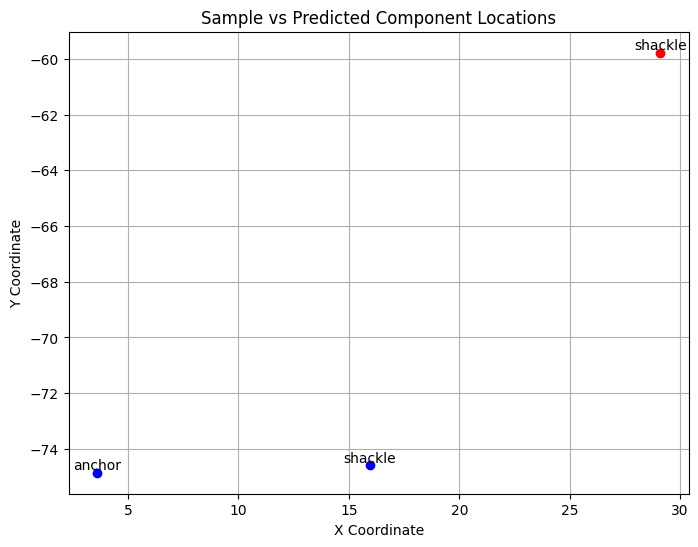

In [181]:
import matplotlib.pyplot as plt

# sample = {'types': [0,1,2], 'locations': [(3.59, -74.86),(15.944,-74.595),(17.404,-75.228)]}
sample = {'types': [0,1], 'locations': [(3.59, -74.86),(15.944,-74.595)]}
# sample = {'types': [7,1,2,7], 'locations': [(9.66, -89.4806),(10.160,-88.415),(12.225,-88.6817),(17.511,-92.143)]}

init_types = torch.tensor(sample['types'], dtype=torch.long).unsqueeze(0).to(device)
init_locations = torch.tensor(sample['locations'], dtype=torch.float).unsqueeze(0).to(device)
next_type, next_location = predict_next(model, init_types, init_locations, device)
print("Predicted next component type:", type_mapping_reverse.get(next_type, "Unknown Type"))
print("Predicted next component location:", next_location)

plt.figure(figsize=(8, 6))

# Plot the sample data and add labels
sample_locations = sample['locations']
sample_x = [loc[0] for loc in sample_locations]
sample_y = [loc[1] for loc in sample_locations]
sample_types = sample['types']  # Get the types from the sample data

for i in range(len(sample_x)):
    plt.scatter(sample_x[i], sample_y[i], color='blue')
    plt.text(sample_x[i], sample_y[i], type_mapping_reverse.get(sample_types[i], "Unknown Type"), ha='center', va='bottom')


# Plot the predicted component and add label
plt.scatter(next_location[0], next_location[1], color='red')
plt.text(next_location[0], next_location[1], type_mapping_reverse.get(next_type, "Unknown Type"), ha='center', va='bottom')

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Sample vs Predicted Component Locations")
plt.grid(True)
plt.show()